Use conda environment `conda_envs/hic_nikita.yml` to run this notebook.

In [1]:
import sys
sys.path.append('../scripts')

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.api.types import CategoricalDtype

# Some additional for plots
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

import cooler # Hi-C data processing
import networkx as nx # Network analysis
import pingouin as pg # Statistics

# Some utils for notebook
from tqdm import tqdm
from IPython.display import display

# Custom
from my_loops_module import *
from my_network_utils import *

/home/nvaulin/tools/mambaforge/envs/hic-env/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [5]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [6]:
from pandas.api.types import CategoricalDtype
regions_groups = {
    'Basal Nuclei': ['AMY', 'CMN', 'CaB', 'GPe', 'BNST', 'NAC', 'Pu'],
    'Basal Forebrain': ['SI', 'SEP'],
    'Cerebral cortex': ['MTG', 'LEC', 'A24', 'A46', 'FI', 'M1C', 'V1C', 'Pir']
}

regions_order = [reg for regs in regions_groups.values() for reg in regs]
reg_type = CategoricalDtype(categories=regions_order, ordered=True)
ct_type = CategoricalDtype(categories=['EN' , 'IN', 'NN'], ordered=True)
chr_type = CategoricalDtype(categories=chroms, ordered=True)


ct_palette = {"EN": "#3924B1",
              "IN": "#C1118C",
              "NN": "#ffc875"}
ct_palette = {"EN": "#cc3412",
              "IN": "#1375bc",
              "NN": "#009a88"}

def get_chr(loop_coords):
    chr1 = loop_coords[0][0]
    chr2 = loop_coords[1][0]
    return chr1 if chr1 == chr2 else 'trans'

chroms_colors = {chroms[i] : plt.get_cmap('tab20b')((i+1) / len(chroms)) for i in range(len(chroms[:-1])) }
chroms_colors['trans'] = (0,0,0)

# Input data:

- `/tank/projects/tian2023/cells_fullmeta_m3C.tsv` - snm3C-seq metadata from *Tian et al., 2023* 
- `data/Tian_cells_contacts_sums.csv` - table with extracted total numbers of contacts per cell from *Tian et al., 2023*
- `data/polycomb_dots_hand_coords_update_June25.tsv` - Polycomb dot coordinates identified in this paper
- `data/polycomb_dots_intensities_pad10kb_EN_IN_NN.csv` - Polycomb dot intensities identified in this paper (in notebook *code/Loops_vs_Expression/2_Get_sc_loops_intensities.ipynb*)

Not in the repository:
- `data/polycombed_genes_activity_in_cerebral_cortex.csv` - this paper, from notebook *3_Get_genes_expression_and_activity.ipynb*
- `data/polycomb_loop_clusters_update_June25.tsv` - this paper, from notebook *4_Heatmaps_by_CellType_and_MajorType.ipynb*
- `data/pcg_loops_groupedMaJType_norm_whole_update_June25.pkl` - this paper, from notebook *4_Heatmaps_by_CellType_and_MajorType.ipynb*



In [ ]:
data_dir = '../../data/'

In [7]:
tian_wd = '/tank/projects/tian2023/'
m3C_meta = pd.read_csv(os.path.join(tian_wd, 'cells_fullmeta_m3C.tsv'), sep='\t', index_col=0)
m3C_meta = m3C_meta.query('Cool_name != "GSM7346586_HBA_220615_H1930004_CX46_SEP_3C_2_P1-4-B11-M20.cool"')

cells_contact_sums = pd.read_csv('/tank/projects/nvaulin_hic_sch/tian_polycomb_analysis/Tian_cells_contacts_sums.csv', index_col=0)
cells_contact_sums.index.name = 'cell'

In [8]:
tian_to_siletti = {
'Amy-Exc':  [153, 154, 155, 156, 157, 158, 159, 160, 161, 162],
'L2/3-IT': [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 134],
'L4-IT': [138, 141],
'L5-ET': [],
'L5-IT': [142, 143, 144],
'L5/6-NP': [86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96],
'L6-CT': [109, 110],
'L6-IT': [148, 149],
'L6-IT-Car3': [150, 151],
'L6-IT-Car3': [152],
'L6b': [98, 99, 101, 103, 105, 106],
'Lamp5': [286, 287, 288],
'Lamp5-Lhx6': [270, 271, 272, 274, 275],
'Pvalb': [240, 255, 256, 257, 258, 259, 260, 261, 262, 263],
'Pvalb-ChC': [264, 265],
'Sncg': [282, 283],
'Sst': [241, 242, 243, 248, 249, 250, 251, 252, 253, 254],
'Vip': [284, 285, 289, 290, 291, 292, 293, 294, 295, 296],
'Chd7': [],
'Foxp2': [229],
'MSN-D1': [209, 210, 211, 214, 215, 219, 220, 227, 228, 230, 231, 232, 234],
'MSN-D2': [207, 208, 212, 213, 216, 217, 221],
'SubCtx-Cplx': [],
'ASC': [52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64],
'OPC': [32, 33, 34, 35, 36],
'ODC': [40, 44, 45, 46, 47, 48, 49, 50],
'MGC': [4, 5, 6, 7, 8, 9, 10, 11, 12],
'PC': [],
'VLMC': [21, 22, 23, 25, 26, 27, 28],
'EC': [14, 15, 16, 17]
}
siletti_to_tian = {v: k for k, vs in tian_to_siletti.items() for v in vs}

majtypes_selected = list(pd.read_pickle(data_dir + 'pcg_loops_groupedMaJType_norm_whole_update_June25.pkl').index)
siletti_to_tian = {k: v for k, v in siletti_to_tian.items() if v in majtypes_selected}

In [9]:
CSR_Exprs_gb_cc_classes = pd.read_csv(data_dir + 'polycombed_genes_activity_in_cerebral_cortex.csv', header=None, names=['gene', 'status']).set_index('gene')['status'].to_dict()

In [10]:
# expressions = pd.read_pickle('polycombed_genes_expressions_June25.pkl')
cells_meta = pd.read_pickle('/tank/projects/nvaulin_hic_sch/tian_polycomb_analysis/siletti_cells_metainfo.pkl')
majtype_to_cc = m3C_meta.set_index('MajorType')['CellClass'].to_dict()

import scipy.sparse as sp
CSR_Exprs = sp.vstack(expressions.CSR_Exprs.values)
CSR_Exprs = pd.DataFrame(CSR_Exprs.toarray(), index=expressions.index, columns=cells_meta['CellID']).T
CSR_Exprs = CSR_Exprs.div(CSR_Exprs.sum(axis=1), axis=0) * 1e4
CSR_Exprs = np.log1p(CSR_Exprs)

CSR_Exprs.to_pickle(data_dir + 'polycombed_genes_expressions_June25_log1pCP10K.pkl')
CSR_Exprs = pd.read_pickle(data_dir + 'polycombed_genes_expressions_June25_log1pCP10K.pkl')

In [12]:
# CSR_Exprs = CSR_Exprs[CSR_Exprs.gt(0).sum(axis=1) > 5] 

In [13]:
rnasseq_celtypes = cells_meta.query("ROIGroupCoarse=='Cerebral cortex'").set_index('CellID')['Clusters'].map(siletti_to_tian).dropna().map(majtype_to_cc).dropna()
CSR_Exprs_gb = CSR_Exprs.join(rnasseq_celtypes).groupby('Clusters').mean()

In [ ]:
polycomb_loops_clusters = pd.read_csv(data_dir + 'polycomb_loop_clusters_update_June25.tsv', index_col=0)

# 1. Compare loop intensity and gene expression aggregated

In [15]:
def mark_loops_activity(row):
    gene1, gene2 = row['gene1'], row['gene2']
    genes = list(set(gene1.split(',') + gene2.split(',')))
    genes = [g for g in genes if g != '-' and g in CSR_Exprs_gb_cc_classes]
    activities = {g: CSR_Exprs_gb_cc_classes[g] for g in genes}
    if set(activities.values()) <= set(['Non-active', 'Part. active']):
        return [g for g,a in activities.items() if a == 'Part. active']
    else:
        return None


def mark_loops_activity(row):
    gene1, gene2 = row['gene1'], row['gene2']
    genes1 = list(set(gene1.split(',')))
    genes2 = list(set(gene2.split(',')))
    genes1 = [g for g in genes1 if g != '-' and g in CSR_Exprs_gb_cc_classes]
    genes2 = [g for g in genes2 if g != '-' and g in CSR_Exprs_gb_cc_classes]

    
    activities1 = {g: CSR_Exprs_gb_cc_classes[g] for g in genes1}
    activities2 = {g: CSR_Exprs_gb_cc_classes[g] for g in genes2}

    if set(activities1.values()) == {'Non-active'} and set(activities2.values()) == {'Non-active'}:
        return list(set(genes1 + genes2))
    elif set(activities1.values()) == {'Non-active'}:
        return genes1
    elif set(activities2.values()) == {'Non-active'}:
        return genes2
    else:
        return None


def mark_loops_activity(row):
    gene1, gene2 = row['gene1'], row['gene2']
    genes1 = list(set(gene1.split(',')))
    genes2 = list(set(gene2.split(',')))
    genes1 = [g for g in genes1 if g != '-' and g in CSR_Exprs_gb_cc_classes]
    genes2 = [g for g in genes2 if g != '-' and g in CSR_Exprs_gb_cc_classes]

    
    activities1 = {g: CSR_Exprs_gb_cc_classes[g] for g in genes1}
    activities2 = {g: CSR_Exprs_gb_cc_classes[g] for g in genes2}

    if set(activities1.values()) == {'Non-active'} and set(activities2.values()) == {'Non-active'}:
        return None
    elif set(activities1.values()) == {'Non-active'}:
        return [g for g,a in activities2.items() if a in ['Part. active', 'Active']]
    elif set(activities2.values()) == {'Non-active'}:
        return [g for g,a in activities1.items() if a in ['Part. active', 'Active']]
    else:
        return None

In [16]:
valuable_genes = polycomb_loops_clusters.apply(mark_loops_activity, axis=1).explode().dropna().unique()

In [17]:
print(len(valuable_genes))
print(sorted(valuable_genes))

125
['AC007405.2', 'AC010997.3', 'AC019068.1', 'AC025171.1', 'AC025171.2', 'AC026704.1', 'AC058822.1', 'AC074099.1', 'AC078909.1', 'AC091959.3', 'AC116345.1', 'ADCYAP1', 'AL354863.1', 'ALX4', 'AP001122.1', 'ASB18', 'BHLHE22', 'BUB3', 'C14orf39', 'C5orf66', 'CCNC', 'CCNO', 'CDCA7', 'CERKL', 'CYP26B1', 'DLX1', 'DLX2', 'DLX5', 'DLX6', 'DLX6-AS1', 'EBF1', 'EBF2', 'EBF3', 'EMX1', 'EMX2', 'EMX2OS', 'ETFA', 'EYA4', 'FEZF2', 'FGF5', 'FLI1', 'FOXC1', 'FOXD1', 'FOXF2', 'GAD1', 'GAD2', 'GATA2', 'GATA2-AS1', 'GDF6', 'HEY2', 'HLX-AS1', 'HMX1', 'HOXD1', 'IGF2BP3', 'INO80B', 'LEF1', 'LEF1-AS1', 'LHX6', 'LIN28B', 'LIN28B-AS1', 'LINC01305', 'LINC02268', 'MECOM', 'MEIS1', 'MEIS2', 'MEOX2', 'MOGS', 'MSX1', 'MYO3B', 'NR2E1', 'NR4A2', 'NRN1', 'NUP133', 'ONECUT1', 'ONECUT2', 'OSTM1', 'OTX1', 'PAX2', 'PAX6', 'PAX8', 'PCDH8', 'PDGFRA', 'PPIC', 'PRDM1', 'PRDM6', 'PRDM8', 'PROX1', 'RNF220', 'RSRC1', 'SATB2', 'SATB2-AS1', 'SCRG1', 'SLC32A1', 'SOX11', 'SOX17', 'SOX2-OT', 'SOX21', 'SOX21-AS1', 'SP5', 'SP8', 'SP9',

In [18]:
loops_of_genes = polycomb_loops_clusters[['gene1', 'gene2', 'cluster_name']]
loops_of_genes['gene'] = loops_of_genes.apply(lambda x: [x['gene1'], x['gene2']], axis=1)
loops_of_genes = loops_of_genes[['gene', 'cluster_name']].explode('gene')
loops_of_genes.gene = loops_of_genes.gene.str.split(',')
loops_of_genes = loops_of_genes.explode('gene').query('gene!="-"')
loops_of_genes = loops_of_genes.value_counts().reset_index().set_index('gene')

/tmp/ipykernel_790232/2150081613.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loops_of_genes['gene'] = loops_of_genes.apply(lambda x: [x['gene1'], x['gene2']], axis=1)


In [19]:
loops_of_genes.loc['TBR1']

,cluster_name,count
gene,,
TBR1,IN-specific,17
TBR1,IN-prevalent,5
TBR1,NN-specific,2


In [20]:
plc = polycomb_loops_clusters.copy()

plc['gene1'] = plc.gene1.str.split(',')
plc['gene2'] = plc.gene2.str.split(',')

plc = plc.explode(['gene1']).explode(['gene2'])[['cluster_name', 'gene1', 'gene2']]
plc = pd.concat([plc.drop(columns='gene1').rename({'gene2': 'gene'},axis=1), plc.drop(columns='gene2').rename({'gene1': 'gene'},axis=1)]).query('gene != "-"')
plc = plc.drop_duplicates()

In [21]:
plc = plc.query('gene.isin(@CSR_Exprs_gb.columns)')
plc = plc.query('gene.isin(@valuable_genes)')
plc['cluster_name_short'] = plc.cluster_name.str.split('-').str[0]
plc['cluster_name_short'] = plc['cluster_name_short'].map(lambda x: {'Neuron': 'Neuron', 'Common': 'Neuron'}.get(x,x))
plc = plc.query('cluster_name_short != "NN"')

In [22]:
import pingouin as pg

In [23]:
plc_gb = plc.groupby('cluster_name')['gene'].agg(lambda x: list(set(list(x)))).to_dict()
plc_gb.keys()

dict_keys(['Common', 'EN-prevalent', 'EN-specific', 'IN-prevalent', 'IN-specific', 'Neuron-specific'])

o < > 8 s p * h H D p

In [24]:
ct_palette = {"EN": "#3924B1",
              "IN": "#C1118C",
              "NN": "#ffc875",
              'Other': 'grey',
              'Neurons': '#bebf23'}

In [59]:
styles = {
('Common', 'NN', 'Neuron'): {'color': ct_palette['Other'], 'style': 'D'},
('Neuron',): {'color': ct_palette['Other'], 'style': 'o'}, 

('EN', 'IN'): {'color': ct_palette['Neurons'], 'style': '8'},
('EN', 'IN', 'Neuron'): {'color': ct_palette['Neurons'], 'style': 'o'},
('EN', 'IN', 'Common'): {'color': ct_palette['Neurons'], 'style': 'p'},
('EN', 'IN', 'Common', 'Neuron'): {'color': ct_palette['Neurons'], 'style': '^'},
('EN', 'Common', 'Neuron', 'IN'): {'color': ct_palette['Neurons'], 'style': '^'},
('EN', 'IN', 'NN'): {'color': ct_palette['Neurons'], 'style': 's'},
('EN', 'IN', 'NN', 'Neuron'): {'color': ct_palette['Neurons'], 'style': '<'},
('EN', 'Common', 'NN', 'IN'): {'color': ct_palette['Neurons'], 'style': '>'},
('NN', 'Neuron', 'Common', 'EN', 'IN'): {'color': ct_palette['Neurons'], 'style': 'D'},
    
('EN',): {'color': ct_palette['EN'], 'style': '8'},
('EN', 'Neuron'): {'color': ct_palette['EN'], 'style': 'o'},
('EN', 'Common'): {'color': ct_palette['EN'], 'style': 'p'},
('EN', 'Common', 'Neuron'): {'color': ct_palette['EN'], 'style': '^'},
('EN', 'Common', 'NN'): {'color': ct_palette['EN'], 'style': '>'},
('EN', 'NN', 'Neuron'): {'color': ct_palette['EN'], 'style': '<'},
('EN', 'Common', 'NN', 'Neuron'): {'color': ct_palette['EN'], 'style': 'D'},
('IN',): {'color': ct_palette['IN'], 'style': '8'},
('IN', 'Neuron'): {'color': ct_palette['IN'], 'style': 'o'},
('IN', 'NN'): {'color': ct_palette['IN'], 'style': 's'},
('IN', 'NN', 'Common'): {'color': ct_palette['IN'], 'style': '>'},
('IN', 'NN', 'Neuron'): {'color': ct_palette['IN'], 'style': '<'},
('IN', 'Common', 'NN', 'Neuron'): {'color': ct_palette['IN'], 'style': 'D'},
('IN', 'NN', 'Common', 'Neuron'): {'color': ct_palette['IN'], 'style': 'D'},
}

styles = {
 ('EN',): {'color': ct_palette['EN'], 'style': 'o'},
 ('IN',): {'color': ct_palette['IN'], 'style': 'o'},
 ('IN', 'EN'): {'color': ct_palette['Neurons'], 'style': 'o'},
 ('Neuron',): {'color': ct_palette['Neurons'], 'style': '^'},
 ('Neuron', 'EN'): {'color': ct_palette['EN'], 'style': '^'},
 ('Neuron', 'IN'): {'color': ct_palette['IN'], 'style': '^'},
 ('Neuron', 'IN', 'EN'): {'color': ct_palette['Neurons'], 'style': 'v'},
}

In [60]:
from adjustText import adjust_text

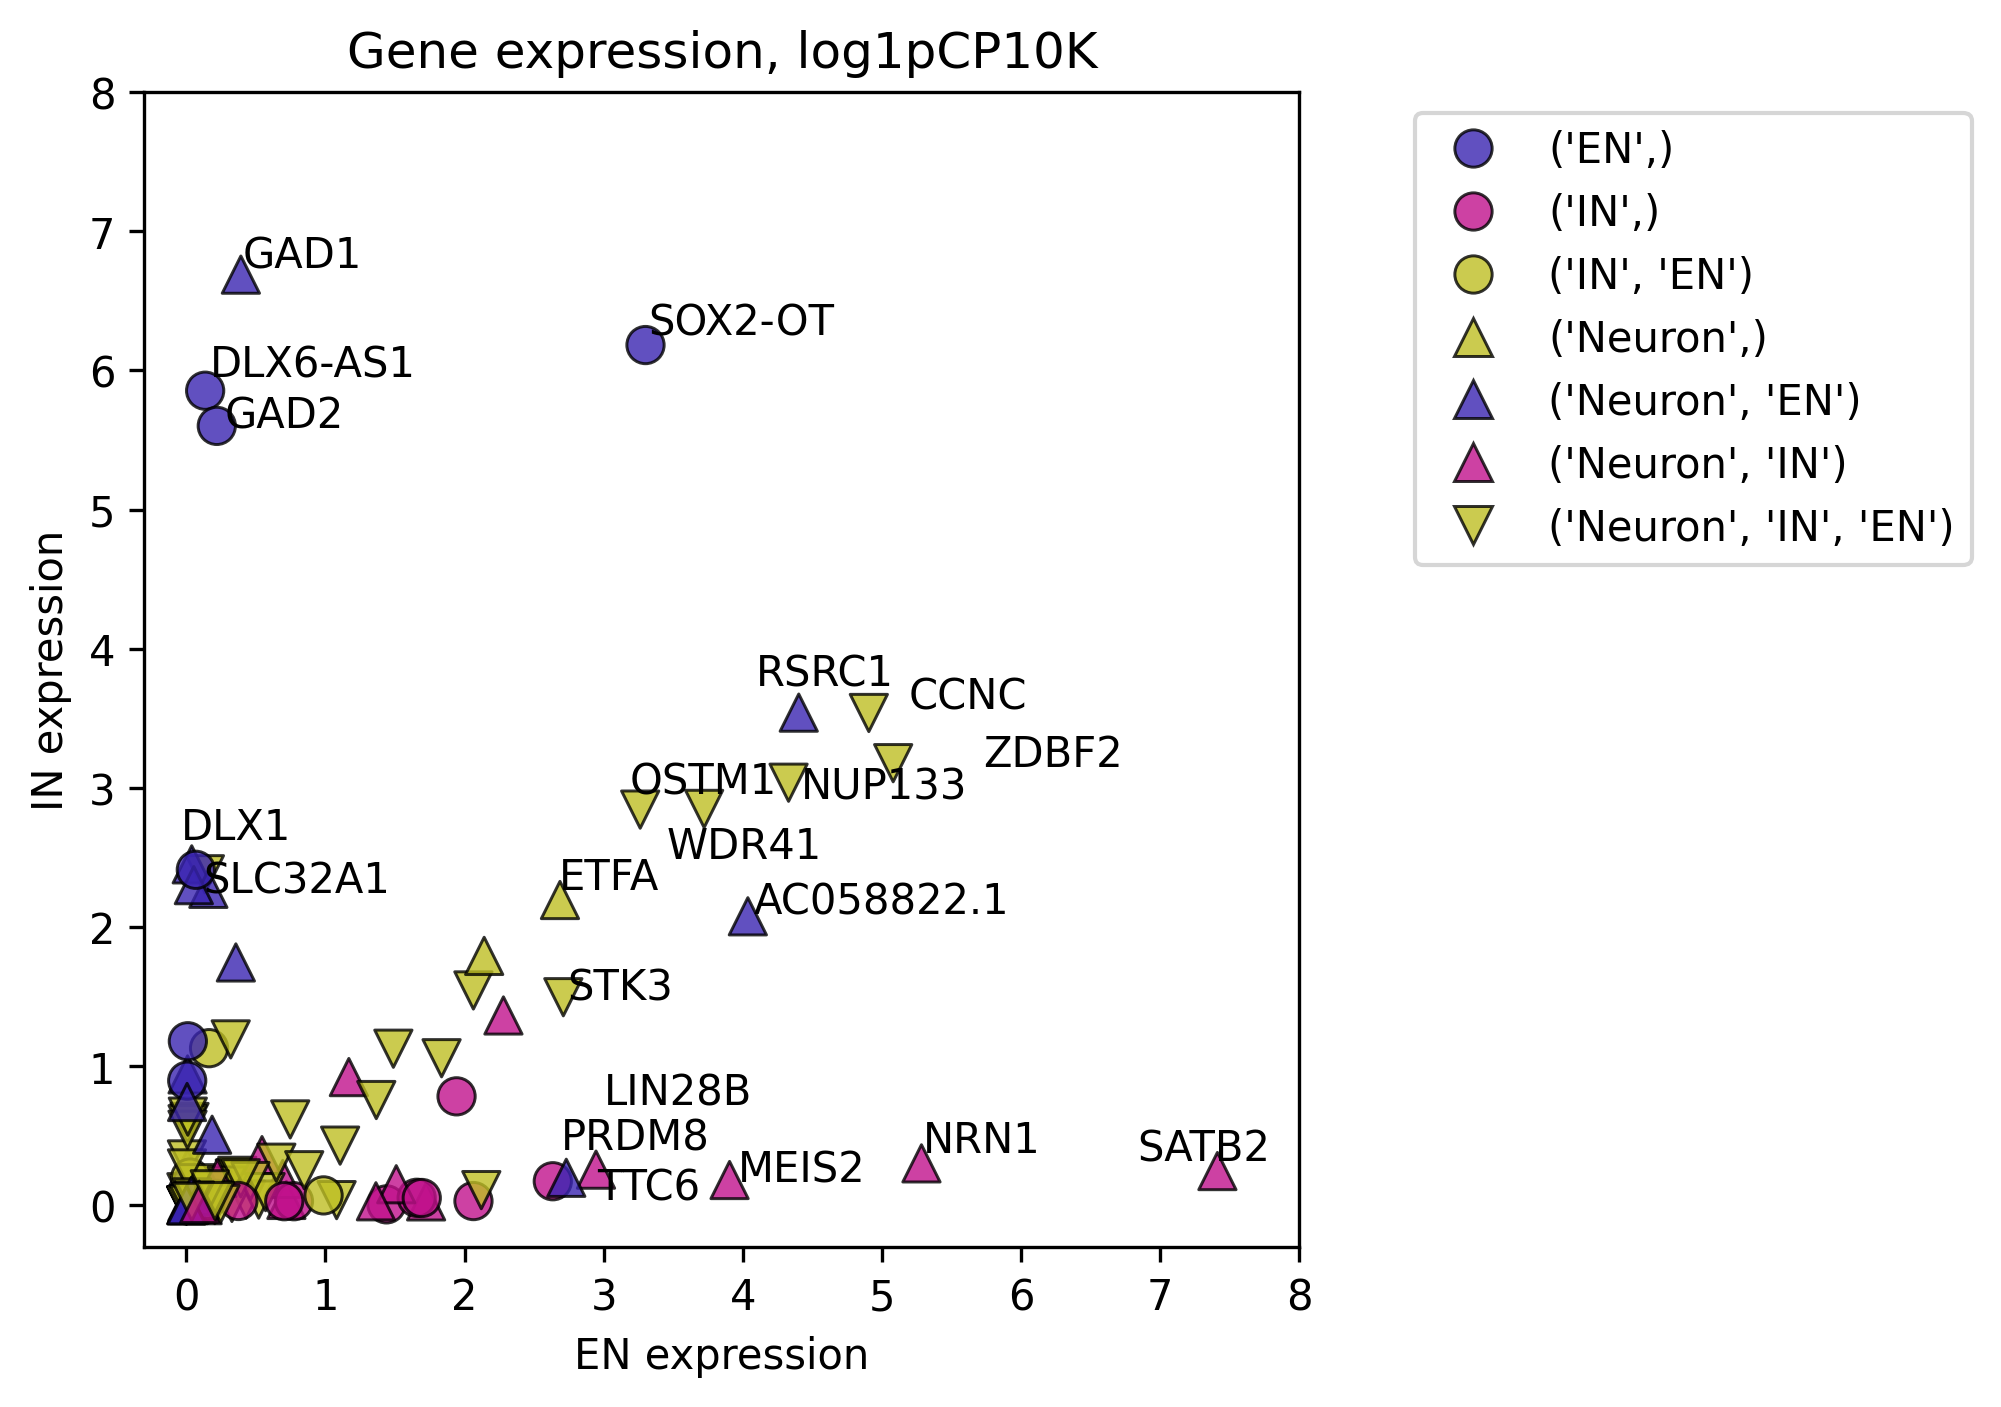

In [61]:
plt.figure(figsize=(5,5), dpi=300)

df = CSR_Exprs_gb.T.loc[valuable_genes]
df = df.join( plc.groupby('gene').cluster_name_short.agg(lambda x:  tuple(set(sorted(x))) ) )
df.cluster_name_short = df.cluster_name_short.astype(pd.CategoricalDtype(styles.keys(), ordered=True))

sns.scatterplot(df, x='EN', y='IN',
                s=80, alpha=.8, edgecolor='k',
                hue='cluster_name_short', style = 'cluster_name_short',
                palette={k: v['color'] for k, v in styles.items()},
                markers={k: v['style'] for k, v in styles.items()},
               )

texts = []
for gene, data in pd.concat([df.nlargest(16, 'EN'), df.nlargest(12, 'IN')]).drop_duplicates().iterrows():
    t = plt.gca().text(x=data['EN'], y=data['IN'], s=gene, fontsize=10)
    texts.append(t)
adjust_text(texts)


plt.legend(bbox_to_anchor=(1.6,1))
plt.xlim(-0.3, 8)
plt.ylim(-0.3, 8)
plt.gca().set_aspect(1)

plt.title('Gene expression, log1pCP10K')
plt.xlabel('EN expression')
plt.ylabel('IN expression')

# plt.savefig('imgs/Fig1C_Expression_EN_IN.pdf', bbox_inches='tight')

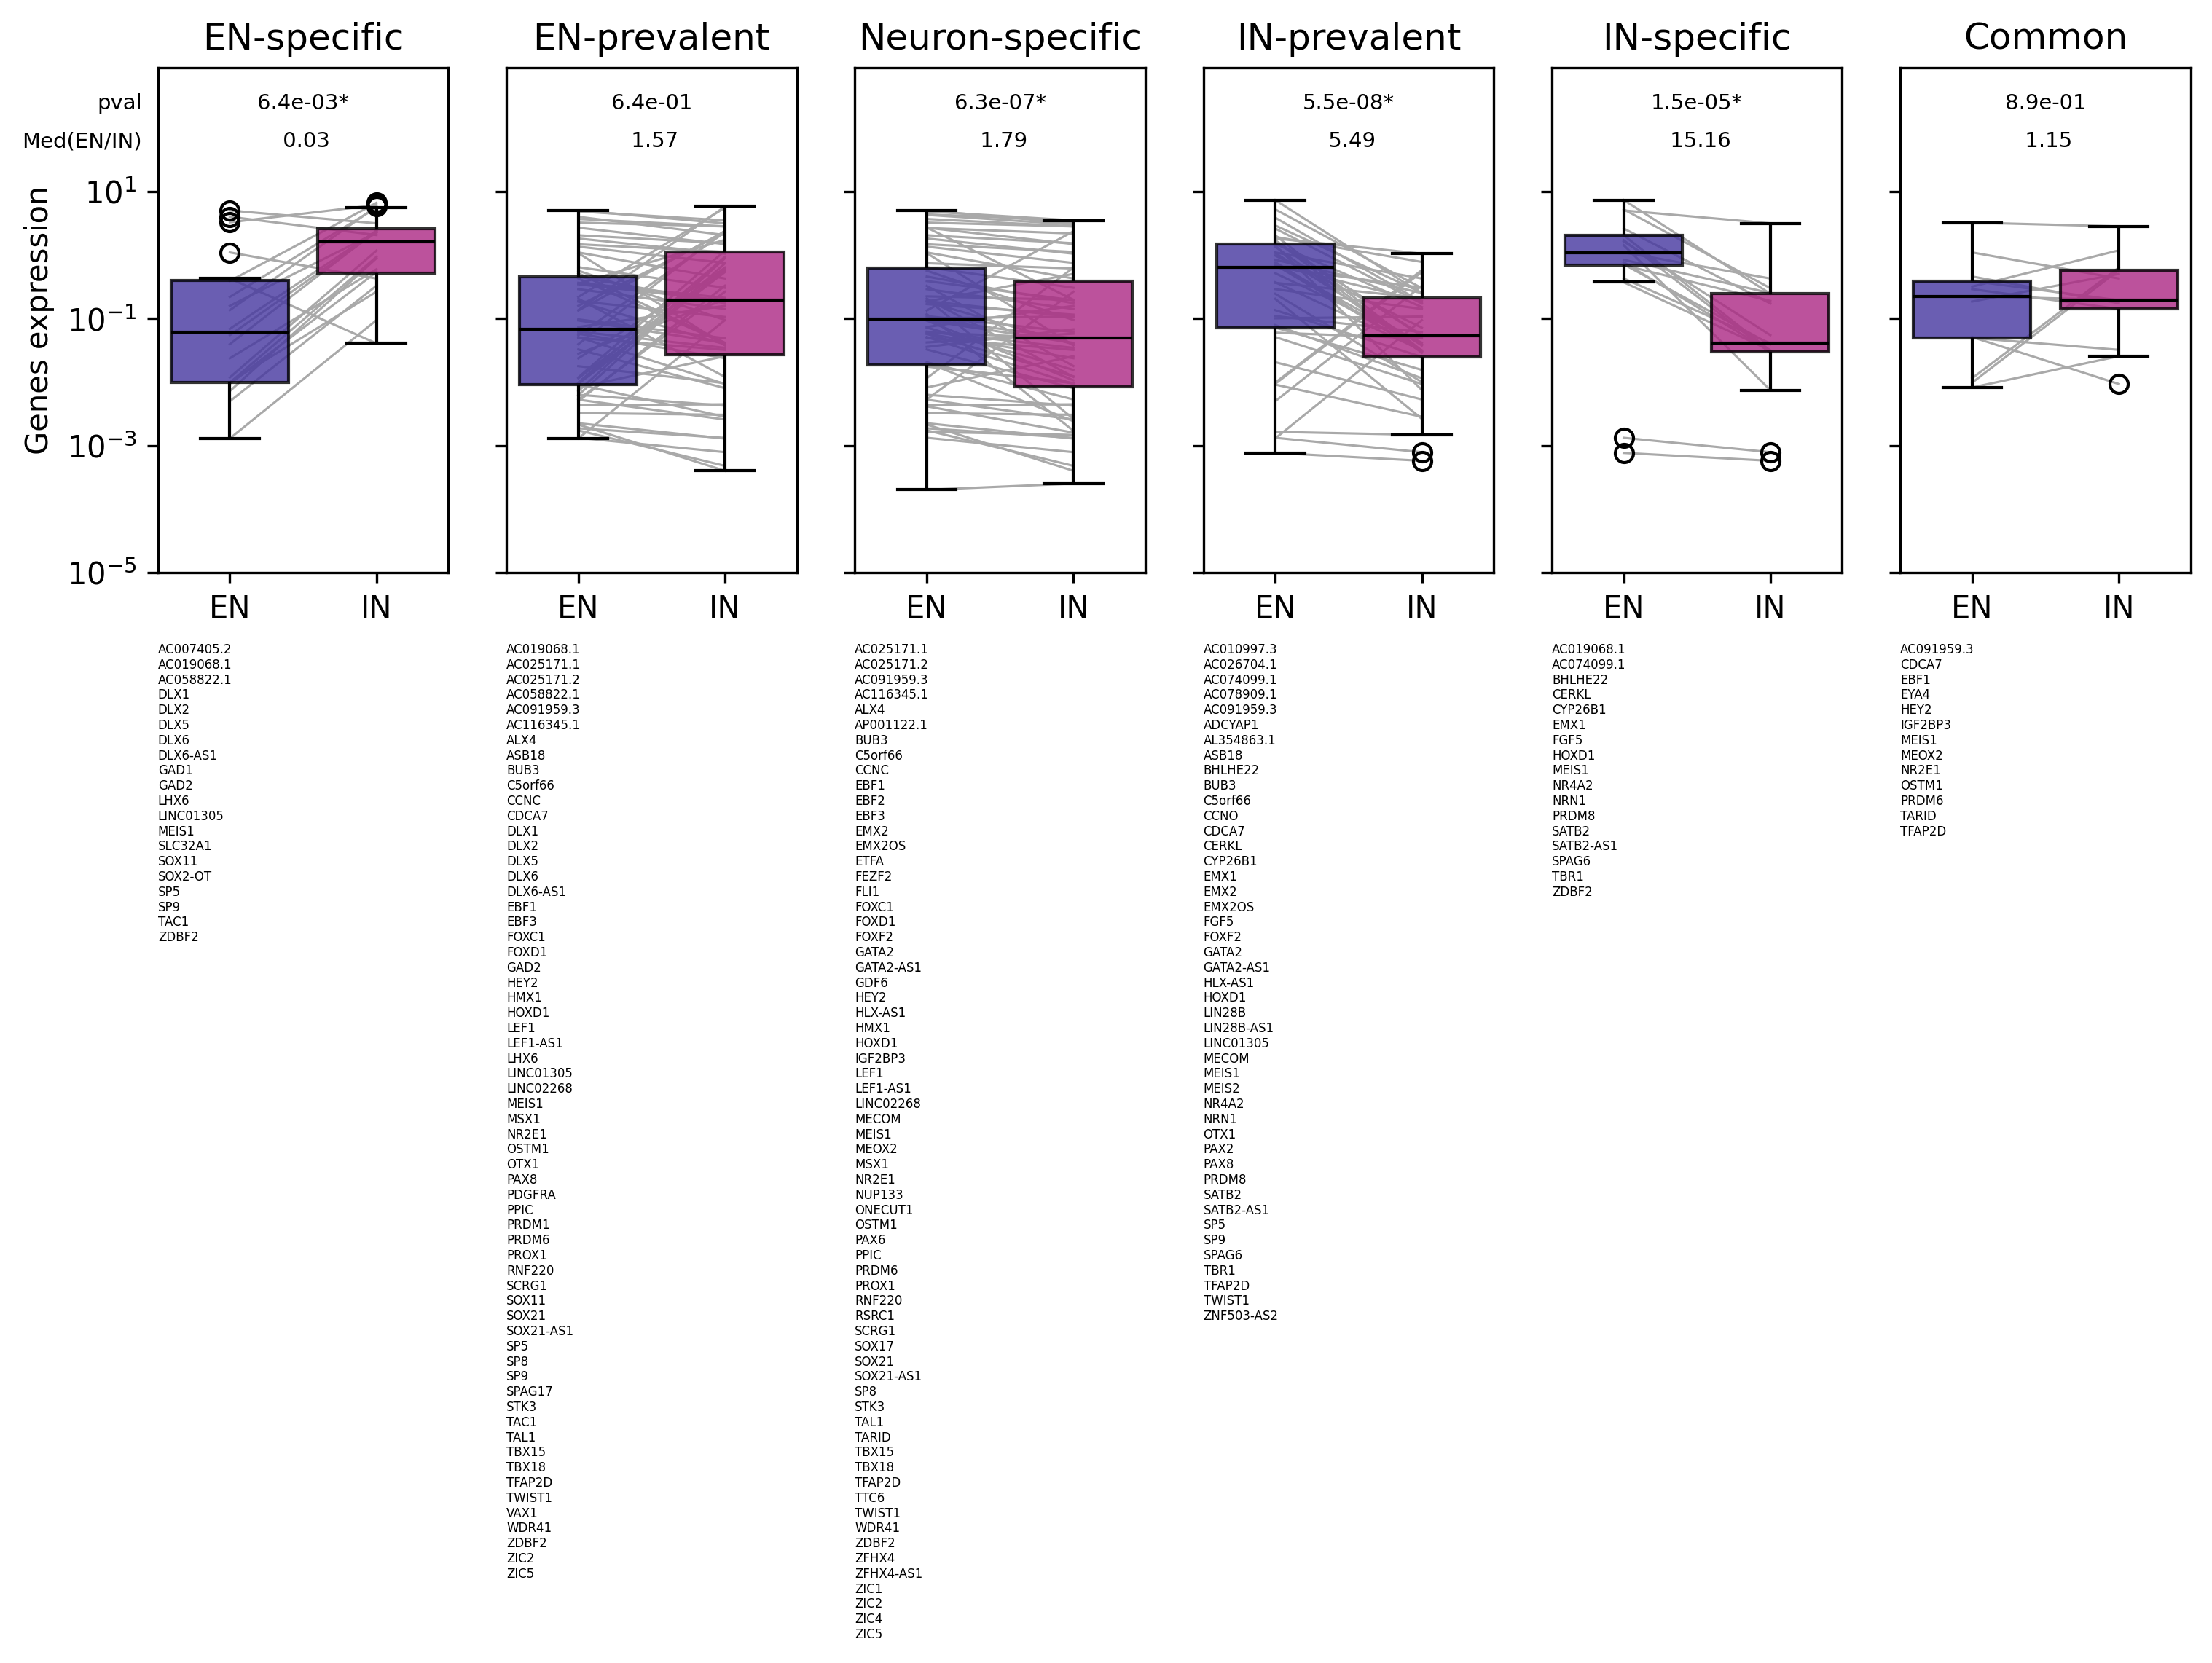

In [38]:
fig, axs = plt.subplots(figsize=(12, 3), ncols=len(plc_gb), nrows=1,
                        dpi=300,
                       sharey=True)
clusters = (
    'EN-specific',
    'EN-prevalent',
    'Neuron-specific',
    'IN-prevalent',
    'IN-specific',
    # 'NN-specific',
    'Common',
    # 'IN-NN',
)
for ax, cluster in zip(axs, clusters):
    ax.set_title(cluster)
    genes = plc_gb[cluster]
    genes = [g for g in genes if loops_of_genes.query('cluster_name==@cluster')['count'].at[g] > 2]

    # sns.boxplot(CSR_Exprs_gb.loc[['EN', 'IN']][genes].T, ax=ax)

    df = CSR_Exprs_gb.loc[['EN', 'IN']][genes].T
    df_long = pd.concat([df['EN'], df['IN']], axis=0, keys=['EN', 'IN']).reset_index()
    df_long.columns = ['CellClass', 'Gene', 'Expression']

    
    sns.boxplot(df, ax=ax, linecolor='k', palette=ct_palette, boxprops=dict(alpha=.8))
    sns.lineplot(x='CellClass', y='Expression', data=df_long, hue='Gene', 
                 palette=['darkgrey'] * len(df_long['Gene'].unique()),
                 linewidth=0.01, size=.3,
                 legend=False, ax=ax, zorder=-2)

    x = CSR_Exprs_gb[genes].T['EN']
    y = CSR_Exprs_gb[genes].T['IN']
    test = pg.wilcoxon(x = x, y = y)
    pval = test['p-val'].iat[0]
    sign = '' if pval > 0.05 else '*'
    
    ax.text(0.5, 2e2, f'{pval:.1e}' + sign, fontsize=7, ha='center')
    ax.text(0.5, 5e1, f'{np.median(x / y) : .2f}', fontsize=7, ha='center')
    ax.set_yscale('log')
    ax.set_xlabel('')
    ax.set_ylim(1e-5, 9e2)
    ax.set_yticks([1e-5, 1e-3, 1e-1, 1e1])
    ax.minorticks_off()
    ax.text(x=0, y=-.14, s='\n'.join(sorted(genes)), va='top', fontsize=4, transform=ax.transAxes)

axs[0].text(-0.6, 2e2, 'pval', fontsize=7, ha='right')
axs[0].text(-0.6, 5e1, 'Med(EN/IN)', fontsize=7, ha='right')
axs[0].set_ylabel('Genes expression')

# plt.savefig('imgs/Fig1C_Expression_EN_IN_Boxplots_logscale.pdf', bbox_inches='tight')

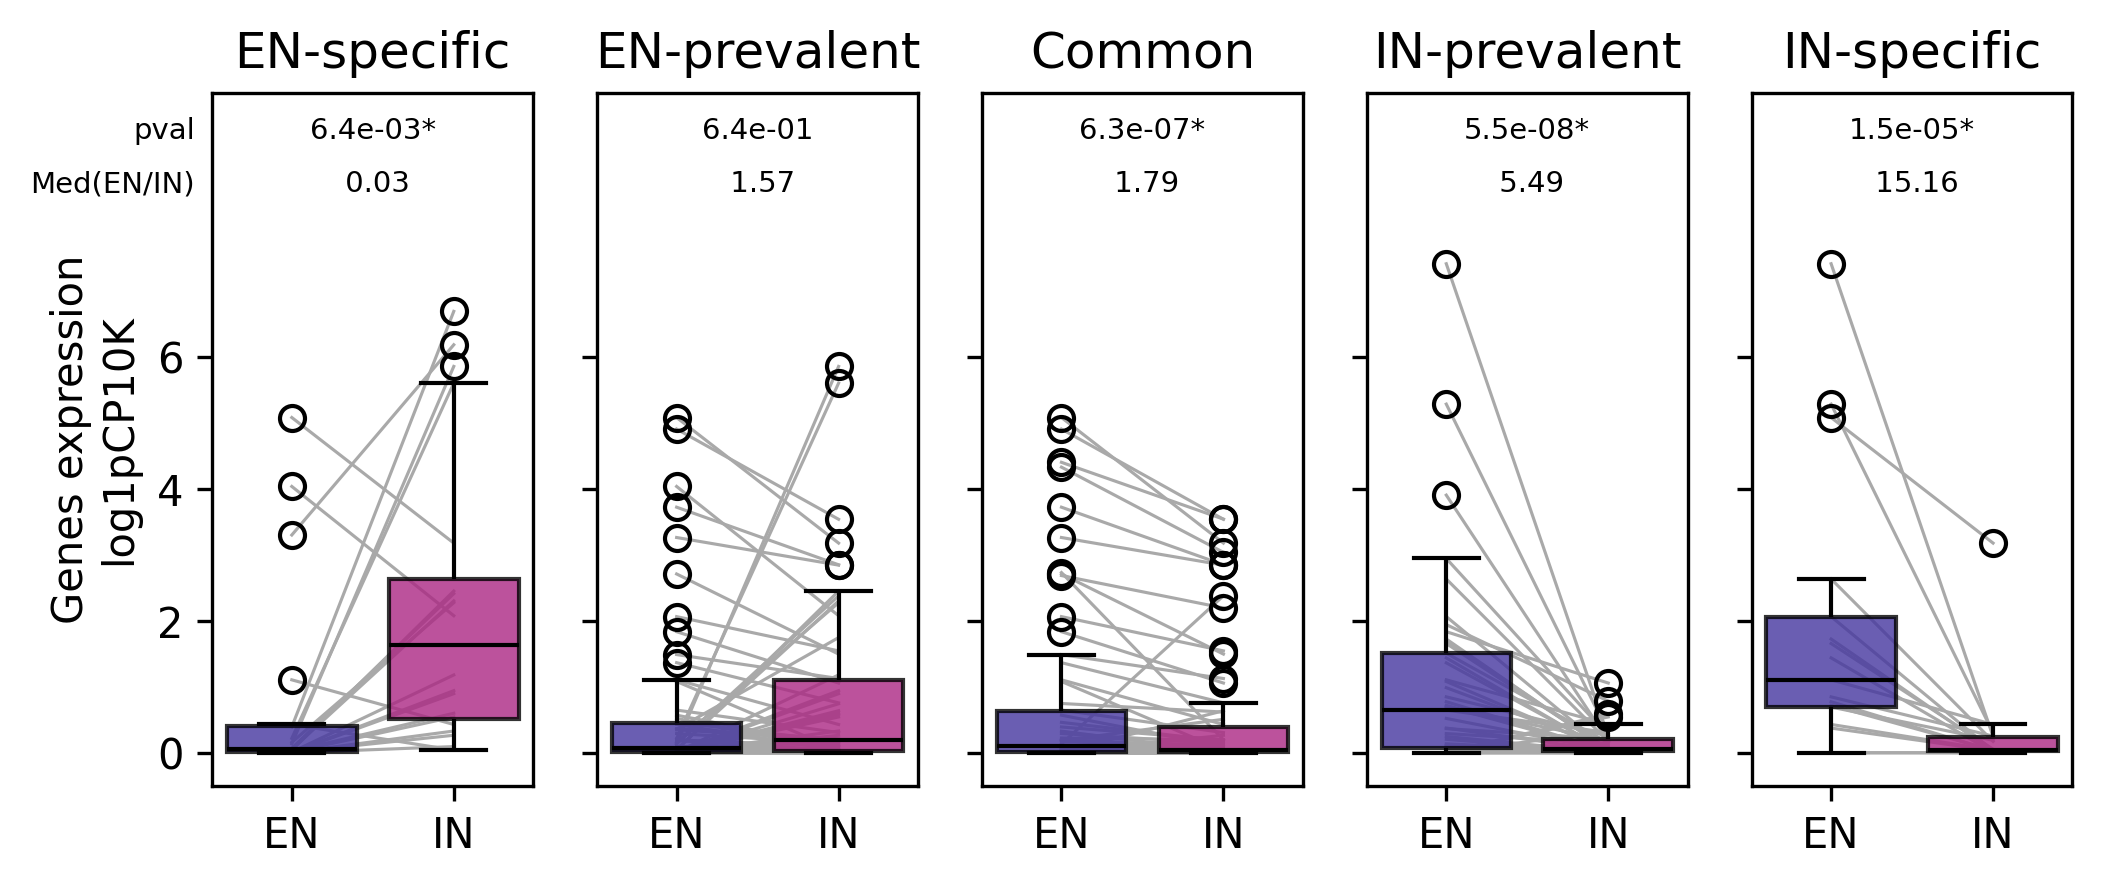

In [46]:
fig, axs = plt.subplots(figsize=(8, 3), ncols=len(plc_gb)-1, nrows=1,
                        dpi=300,
                       sharey=True)
clusters = (
    'EN-specific',
    'EN-prevalent',
    'Neuron-specific',
    'IN-prevalent',
    'IN-specific',
    # 'NN-specific',
    # 'Common',
    # 'IN-NN',
)
for ax, cluster in zip(axs, clusters):
    ax.set_title(cluster)
    if cluster == 'Neuron-specific':
        ax.set_title('Common')
        
    genes = plc_gb[cluster]
    genes = [g for g in genes if loops_of_genes.query('cluster_name==@cluster')['count'].at[g] > 2]

    # sns.boxplot(CSR_Exprs_gb.loc[['EN', 'IN']][genes].T, ax=ax)

    df = CSR_Exprs_gb.loc[['EN', 'IN']][genes].T
    df_long = pd.concat([df['EN'], df['IN']], axis=0, keys=['EN', 'IN']).reset_index()
    df_long.columns = ['CellClass', 'Gene', 'Expression']

    
    sns.boxplot(df, ax=ax, linecolor='k', palette=ct_palette, boxprops=dict(alpha=.8))
    sns.lineplot(x='CellClass', y='Expression', data=df_long, hue='Gene', 
                 palette=['darkgrey'] * len(df_long['Gene'].unique()),
                 linewidth=0.01, size=.3,
                 legend=False, ax=ax, zorder=-2)

    x = CSR_Exprs_gb[genes].T['EN']
    y = CSR_Exprs_gb[genes].T['IN']
    test = pg.wilcoxon(x = x, y = y)
    pval = test['p-val'].iat[0]
    sign = '' if pval > 0.05 else '*'
    
    ax.text(0.5, 9.3, f'{pval:.1e}' + sign, fontsize=7, ha='center')
    ax.text(0.5, 8.5, f'{np.median(x / y) : .2f}', fontsize=7, ha='center')
    # ax.set_yscale('log')
    ax.set_xlabel('')
    ax.set_ylim(-.5, 10)
    ax.set_yticks([0, 2, 4, 6])
    ax.minorticks_off()
    # ax.text(x=0, y=-.14, s='\n'.join(sorted(genes)), va='top', fontsize=4, transform=ax.transAxes)

axs[0].text(-0.6, 9.3, 'pval', fontsize=7, ha='right')
axs[0].text(-0.6, 8.5, 'Med(EN/IN)', fontsize=7, ha='right')
axs[0].set_ylabel('Genes expression\nlog1pCP10K')

# plt.savefig('imgs/Fig1C_Expression_EN_IN_Boxplots.pdf', bbox_inches='tight')

# Compare loop intensity and gene expression for each gene separately

In [225]:
rnasseq_celtypes = cells_meta.query("ROIGroupCoarse=='Cerebral cortex'").set_index('CellID')['Clusters'].map(siletti_to_tian).dropna()
CSR_Exprs_gb = CSR_Exprs.join(rnasseq_celtypes).groupby('Clusters').mean()

In [226]:
CSR_Exprs_gb

,AC003986.3,AC004080.2,AC004080.4,AC004080.5,AC005224.2,AC007405.2,AC008060.2,AC008060.3,AC008406.3,AC008808.1,...,ZDBF2,ZFHX4,ZFHX4-AS1,ZIC1,ZIC2,ZIC4,ZIC4-AS1,ZIC5,ZNF503,ZNF503-AS2
Clusters,,,,,,,,,,,,,,,,,,,,,
ASC,0.000251,0.000000,0.0,0.0,0.039683,0.006267,0.001245,0.002021,0.0,0.0,...,0.658271,5.889516,1.141840,0.998384,1.068346,0.151187,0.000000,0.915698,0.000298,0.019596
L2/3-IT,0.032808,0.000219,0.0,0.0,0.009741,0.008463,0.002688,0.003359,0.0,0.0,...,5.073568,1.053288,0.049200,0.018563,0.002665,0.005222,0.000013,0.002054,0.004641,0.124325
L4-IT,0.003252,0.000083,0.0,0.0,0.560772,0.014273,0.001283,0.001334,0.0,0.0,...,4.834666,0.049225,0.016179,0.011512,0.004616,0.001068,0.000000,0.002229,0.003966,0.105527
L5-IT,0.053715,0.000000,0.0,0.0,0.005232,0.011751,0.004085,0.006016,0.0,0.0,...,5.360521,0.222227,0.042897,0.018405,0.004394,0.003305,0.000168,0.003535,0.009034,0.224896
L6-IT,0.001294,0.000000,0.0,0.0,0.006440,0.013554,0.003381,0.003948,0.0,0.0,...,5.168414,0.089865,0.027580,0.018442,0.004328,0.001657,0.000000,0.002290,0.007294,0.167661
Lamp5,0.000438,0.000000,0.0,0.0,0.008915,0.434861,0.001913,0.001204,0.0,0.0,...,3.525082,1.431990,0.086048,0.009512,0.002882,0.001315,0.000000,0.001093,0.000119,0.003277
MGC,0.000000,0.000000,0.0,0.0,0.004201,0.002324,0.000499,0.000000,0.0,0.0,...,0.318047,0.052115,0.008611,0.008083,0.006108,0.001993,0.000000,0.003149,0.002698,0.049195
ODC,0.000083,0.000000,0.0,0.0,0.000163,0.000966,0.000926,0.004109,0.0,0.0,...,0.214023,3.432822,0.292181,0.623903,0.007461,0.109525,0.000000,0.007804,0.000000,0.006333
OPC,0.000207,0.000000,0.0,0.0,0.001325,0.057034,0.000446,0.001112,0.0,0.0,...,1.159880,4.727795,1.359849,0.334155,0.012728,0.053424,0.000000,0.008538,0.001406,0.028943


In [195]:
polycomb_dots = pd.read_csv('polycomb_dots_hand_coords_update_June25.tsv', sep='\t', index_col=0)

genes_df_1 = polycomb_dots[['gene1', 'chrom1', 'start1', 'end1']]
genes_df_1.columns = 'gene', 'chrom', 'start', 'end'

genes_df_2 = polycomb_dots[['gene2', 'chrom2', 'start2', 'end2']]
genes_df_2.columns = 'gene', 'chrom', 'start', 'end'

genes_df = pd.concat([genes_df_1, genes_df_2]).drop_duplicates()

genes_df.gene = genes_df.gene.fillna('-').str.split(',')
genes_df = genes_df.explode('gene').drop_duplicates().query('gene != "-"')

In [196]:
pcg_sc_loops = pd.read_csv(data + 'polycomb_dots_intensities_pad10kb_EN_IN_NN.csv', header=[0,1])

In [197]:
cols = [ (c1, c2) for c1, c2 in pcg_sc_loops.columns.tolist()]
cols[0] = 'cell'
cols = list(map(lambda x: x if x == 'cell' else tuple([eval(x[0]), eval(x[1])]), cols))

pcg_sc_loops.columns = cols

pcg_sc_loops = pcg_sc_loops.dropna(subset=['cell']).set_index('cell')
pcg_sc_loops.index = pcg_sc_loops.index.to_series().apply(lambda x: x.lstrip(r'GSM1234567890').removeprefix('_').removesuffix('.cool'))
cells = pcg_sc_loops.index.tolist()

pcg_sc_loops = pcg_sc_loops.astype('float64')

In [198]:
selected_loops = pd.DataFrame(index=pcg_sc_loops.index)
for g, l in genes_df.set_index('gene').iterrows(): 
    l = tuple(l)
    g_loops = pcg_sc_loops.loc[:, [l in c for c  in pcg_sc_loops.columns]].mean(axis=1).to_frame().rename(columns={0:g})
    if g not in selected_loops.columns:
        selected_loops = selected_loops.join(g_loops)
    else:
        selected_loops[g] = pd.concat([g_loops, selected_loops[[g]]], axis=1).mean(axis=1)

In [199]:
selected_loops = selected_loops.join(m3C_meta[['MajorType']])
loops_intens = selected_loops.groupby('MajorType').mean()

In [227]:
CSR_Exprs_gb.index.name = 'Cluster'
loops_intens.index.name = 'Cluster'
exprs_melted = CSR_Exprs_gb.melt(ignore_index=False).rename(columns={'value':'expression', 'variable':'gene'}).reset_index(drop=False).set_index(['Cluster','gene'])
loops_melted = loops_intens.melt(ignore_index=False).rename(columns={'value':'loop', 'variable':'gene'}).reset_index(drop=False).set_index(['Cluster', 'gene'])

In [228]:
loops_and_expressions = exprs_melted.join(loops_melted).reset_index()

## Visualize

In [229]:
en_types = ['L2/3-IT', 'L4-IT', 'L5-IT', 'L6-IT']
in_types = ['Lamp5', 'Pvalb', 'Sncg', 'Sst', 'Vip']
nn_types = ['ASC', 'MGC', 'ODC', 'OPC']


cts = {t: 'EN' for t in en_types} | {t: 'IN' for t in in_types} | {t: 'NN' for t in nn_types}

encm = {en_types[i]: plt.get_cmap('tab10_r')(i/len(en_types)) for i in range(len(en_types))}
incm = {in_types[i]: plt.get_cmap('Set3')(i/len(in_types)) for i in range(len(in_types))}
nncm = {nn_types[i]: plt.get_cmap('Dark2')(i/len(nn_types)) for i in range(len(nn_types))}

cmap = encm | incm | nncm
smap = {'EN': 'o', 'IN': 'X', 'NN':'p'}


## update
cmap = ct_palette
shapes = ['o', 's', '>', '<', 'D', 'H', 'h', '8']

assert len(en_types) <= len(shapes) and len(in_types) <= len(shapes) and len(nn_types) <= len(shapes)
smap = dict(zip(en_types, shapes)) | dict(zip(in_types, shapes)) | dict(zip(nn_types, shapes))

In [230]:
loops_and_expressions['Cell type'] = loops_and_expressions.Cluster.map(cts)

print(loops_and_expressions.isna().sum())
loops_and_expressions = loops_and_expressions.fillna(0)

Cluster        0
gene           0
expression     0
loop          13
Cell type      0
dtype: int64


In [231]:
non_zero_genes = (loops_and_expressions.groupby('gene')[['expression', 'loop']].mean() > 0).all(axis=1)
non_zero_genes = non_zero_genes[non_zero_genes].index.to_list()
loops_and_expressions = loops_and_expressions.query('gene.isin(@non_zero_genes)')


corrs = dict()
for x in loops_and_expressions.groupby('gene')[['expression', 'loop']]:
    corrs[x[0]] = {'pearson': x[1].corr().iloc[0,1]}
corrs = pd.DataFrame(corrs).T
corrs = corrs.sort_values(by='pearson', ascending=True)

In [232]:
loops_and_expressions_by_gene = {gene: data for gene, data in loops_and_expressions.groupby('gene')}

In [273]:
loops_and_expressions.to_csv(data + 'Loops_and_expressions.csv', index=False)

In [233]:
def plot_genes_loops_vs_expression(genes_to_plot, ncols=None, label_first=False):
    if ncols is None:
        ncols = min(len(genes_to_plot), 10)
        
    n_genes = len(genes_to_plot)//ncols
    fig, axs = plt.subplots(ncols=ncols, 
                            nrows=1 * n_genes, 
                            figsize=(1.7*ncols, 2.2* n_genes), 
                            layout='tight',
                            dpi=300)
    axs = axs.ravel()
    
    max_expression = max(v.expression.max() for g, v in loops_and_expressions_by_gene.items() if g in genes_to_plot)
    max_loop = max(v.loop.max() for g, v in loops_and_expressions_by_gene.items() if g in genes_to_plot)
    
    
    for i, (ax, gene) in enumerate(zip(axs, genes_to_plot)):
        gene_df = loops_and_expressions_by_gene[gene]
        sns.scatterplot(gene_df, x='loop' ,y='expression', 
                        hue='Cell type', s=60, lw=.8, edgecolors='k',
                        style='Cluster', markers=smap, 
                        palette=cmap,
                        ax=ax)
    
        ax.axvline(0, lw=.1, c='k', zorder=-1)
        ax.axhline(0, lw=.1, c='k', zorder=-1)
        ax.set_xlim(- max_loop * 0.1, max_loop * 1.1), ax.set_ylim(-max_expression*0.1, max_expression*1.1) 
        
        
        if label_first and i == 0:
            ax.set_ylabel('Mean gene expression')
            ax.set_xlabel('Mean loop intensity')
            ax.set_xticks([0, max_loop], ['0', f'{max_loop:.1e}']), ax.set_yticks([0, max_expression], ['0', f'{max_expression:.1f}'])
        else:
            ax.set_ylabel('')
            ax.set_xlabel('')
            ax.set_xticks([]), ax.set_yticks([])
            
        ax.text(.9, .9, f'{corrs.loc[gene, "pearson"]:.2f}', 
                fontweight='bold',
                ha='right', va='top',
                transform=ax.transAxes)
        ax.get_legend().remove()
        ax.set_title(gene)
        ax.set_box_aspect(1)
    
        

    return axs

In [276]:
l1 = ['TBR1', 'NR4A2', 'PRDM8', 'SATB2', 'FGF5', 'EMX1', 'NRN1', 'SPAG6', 'NEUROD1', 'CYP26B1', 'LIN28B', 'FEZF2']
l2 = ['DLX5', 'DLX6', 'DLX1', 'DLX2', 'GSX2', 'SP5', 'SOX11', 'LHX6', 'GAD1', 'GAD2', 'TAC1', 'SP9', 'PDGFRA', 'CDCA7', 'PROX1', 'SOX2', 'PRDM1', 'VAX1', 'MYO3B']

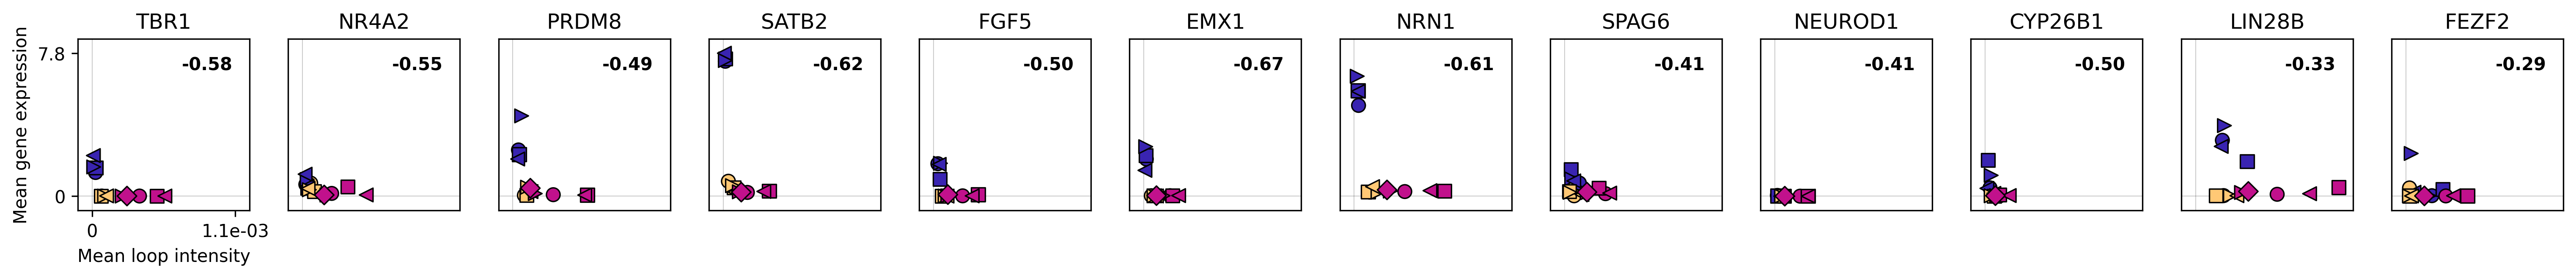

In [277]:
plot_genes_loops_vs_expression(l1, label_first=True, ncols=12);
# plt.savefig('imgs/Fig2C_ExprLoop_1.pdf', bbox_inches='tight')

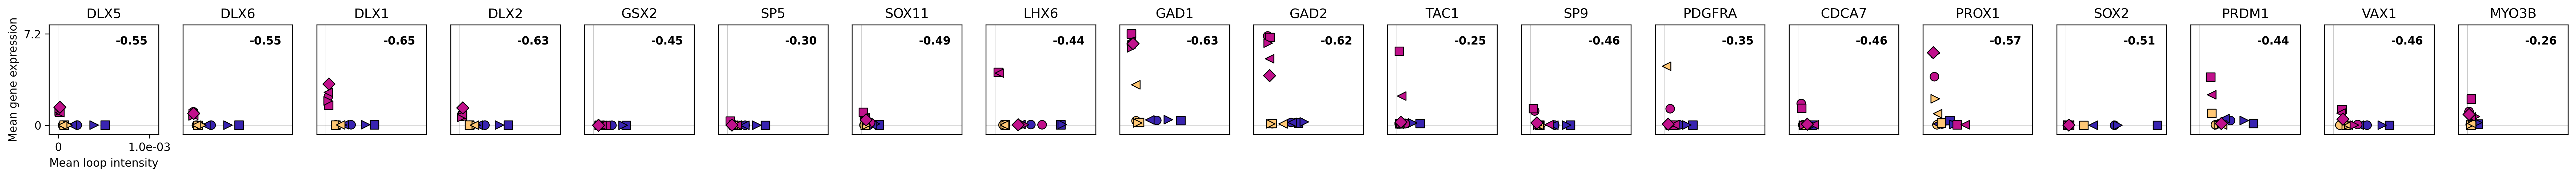

In [278]:
plot_genes_loops_vs_expression(l2, label_first=True, ncols=len(l2));
# plt.savefig('imgs/Fig2C_ExprLoop_2.pdf', bbox_inches='tight')

In [294]:
loops_and_expressions_n = loops_and_expressions[loops_and_expressions['Cell type'] != "NN"]
loops_and_expressions_by_gene_n = {gene: data for gene, data in loops_and_expressions_n.groupby('gene')}

## Select genes with interesting patterns

In [437]:
from sklearn.cluster import KMeans
import scipy

In [583]:
gene_scoring = {}
for gene, df in tqdm(loops_and_expressions_by_gene_n.items()):
    #corr
    X = df[['expression','loop']]
    preds_raw = KMeans(n_clusters=2, random_state=1).fit_predict(X)
    corr =  np.abs(scipy.stats.pearsonr(preds_raw, pd.factorize(df['Cell type'])[0]).statistic)

    # dists
    arr = np.array(df.expression)
    score = sorted(arr)[-1] - sorted(arr)[-2]

    gene_scoring[gene] = {'corr':corr, 'diff_expr': score}

gene_scoring = pd.DataFrame(gene_scoring).T

100%|██████████| 349/349 [00:07<00:00, 46.29it/s]


In [584]:
#gene_scoring = gene_scoring.loc[corrs.query('pearson<0').index]

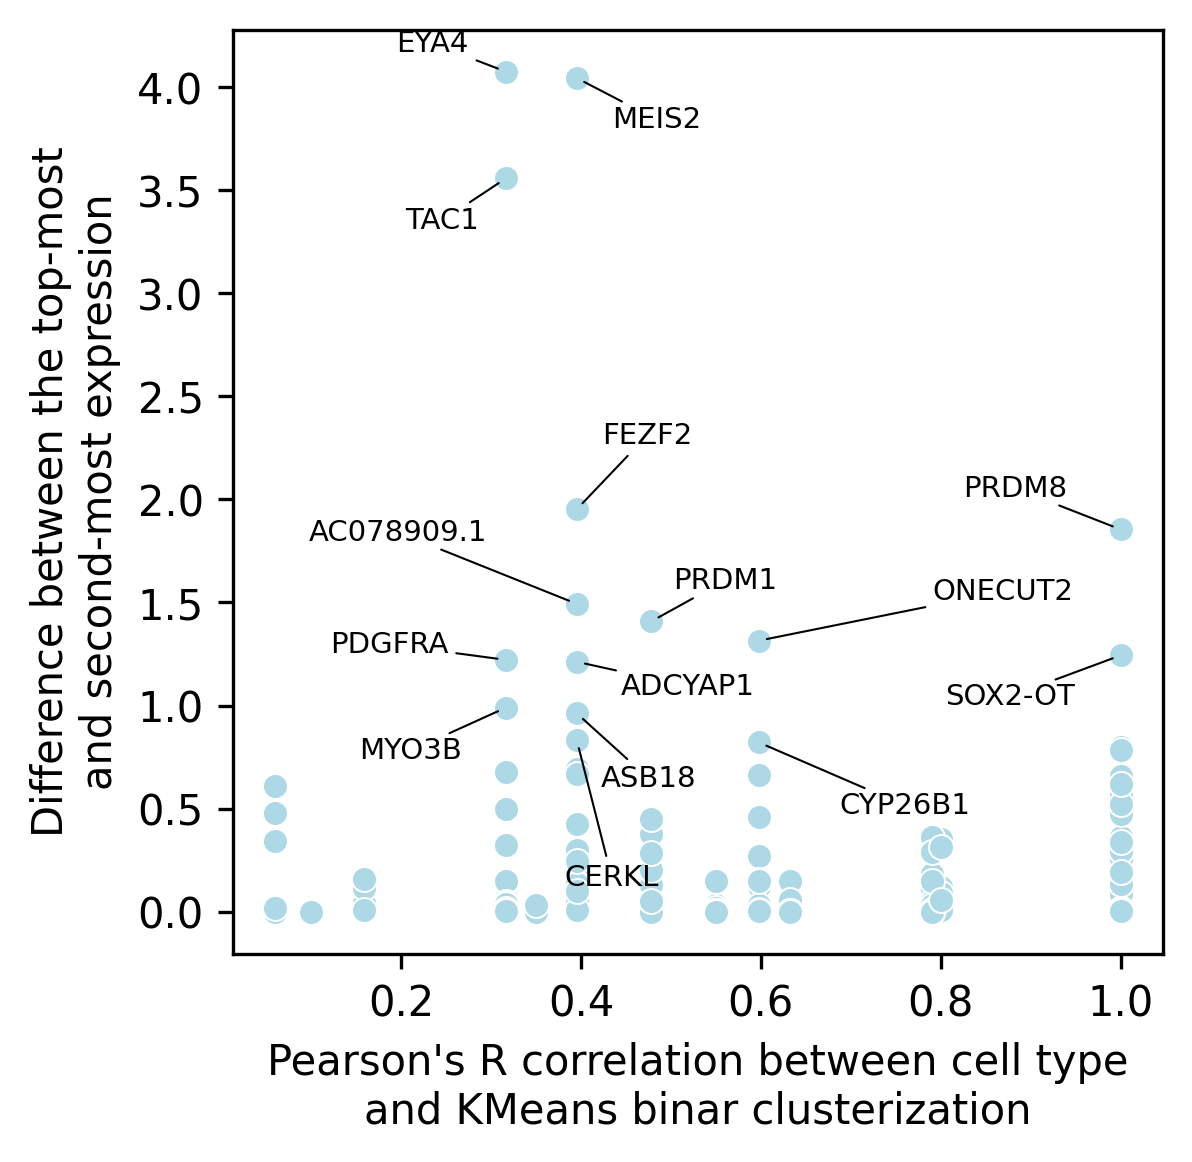

In [585]:

plt.figure(figsize=(4,4), dpi=300)

plot_df = gene_scoring#.query('corr<0.6')
sns.scatterplot(plot_df, x='corr', y='diff_expr', c='lightblue')

n = 15
texts = []
for gene, data in pd.concat([plot_df.nlargest(n, 'diff_expr'), plot_df.nlargest(n, 'diff_expr')]).drop_duplicates().iterrows():
    t = plt.gca().text(x=data['corr'], y=data['diff_expr'], s=gene, fontsize=7, ha='center', va='center')
    texts.append(t)
adjust_text(texts, expand=(2, 3), arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

plt.xlabel("Pearson's R correlation between cell type\nand KMeans binar clusterization")
plt.ylabel('Difference between the top-most\nand second-most expression')

# plt.savefig('imgs/Extra_Scoring_genes_behavior.pdf', bbox_inches='tight')

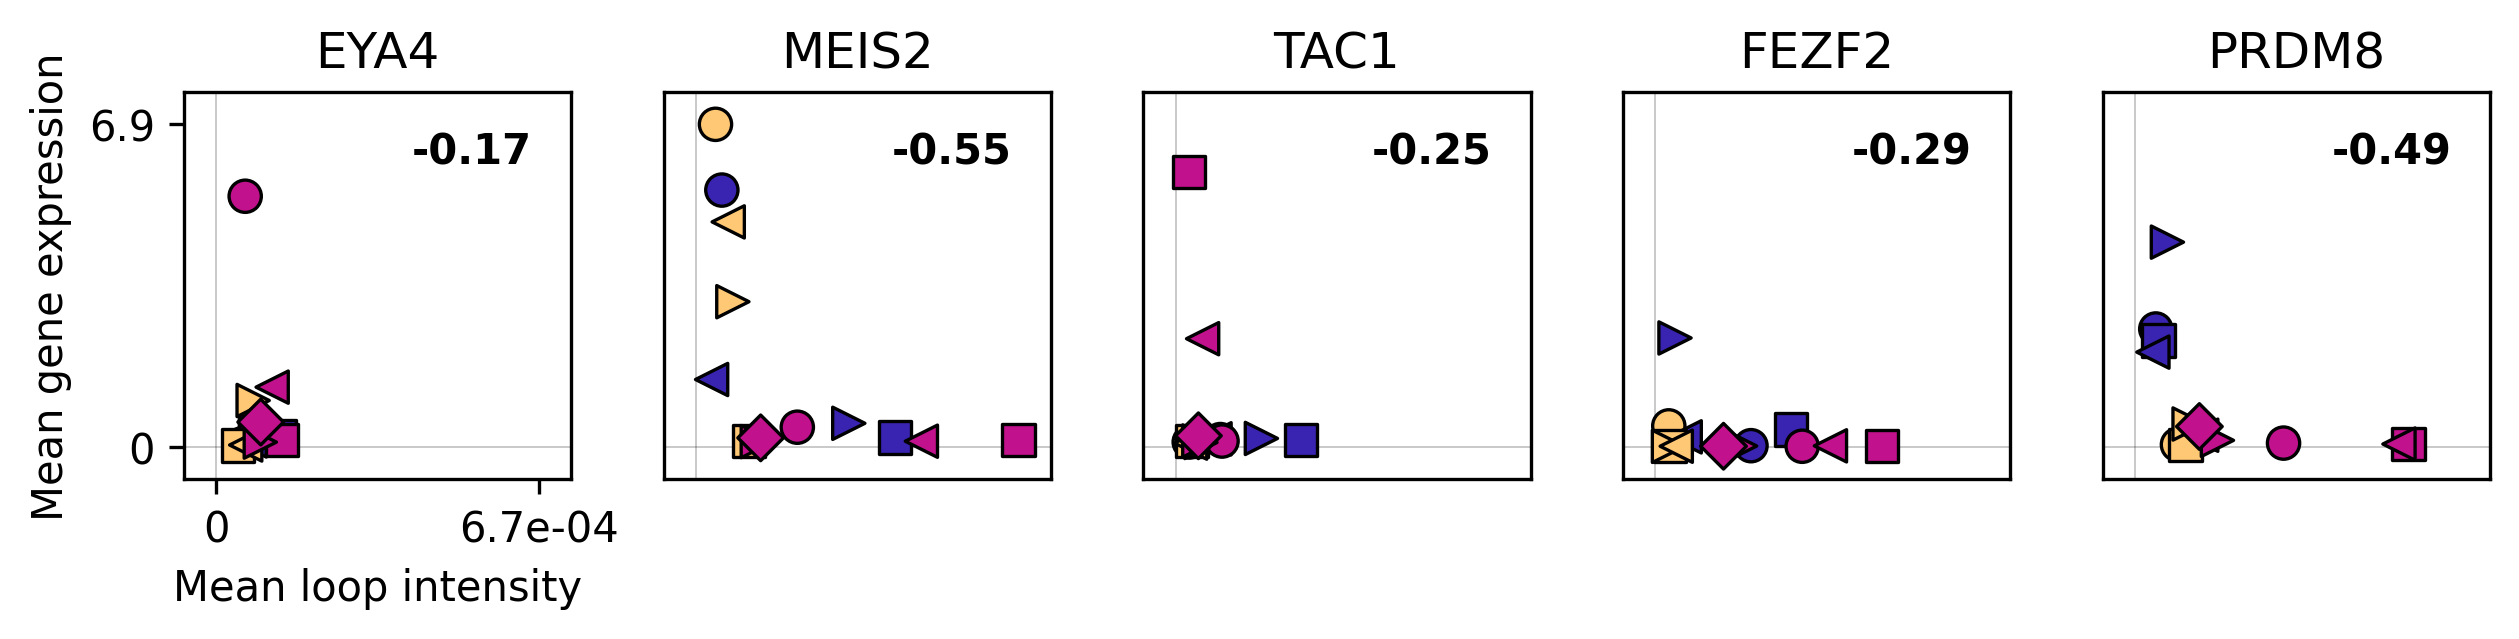

In [586]:
plot_genes_loops_vs_expression(gene_scoring.nlargest(5, 'diff_expr').index, label_first=True);

# plt.savefig('imgs/Extra_Scoring_genes_behavior_examples.pdf', bbox_inches='tight')

## Plot legend

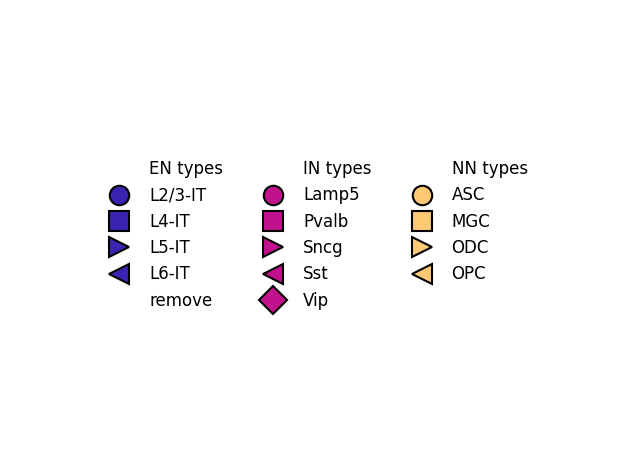

In [244]:
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker=smap[t], color='w', label=t,  # No horizontal line
           markerfacecolor=cmap[cts[t]], markeredgewidth=1.5, markeredgecolor='black', markersize=14) 
    for t in cts
]

legend_elements.insert(4, Line2D([], [], label='remove', color='w'))
legend_elements.insert(0, Line2D([], [], label='EN types', color='w'))
legend_elements.insert(6, Line2D([], [], label='IN types', color='w'))
legend_elements.insert(12, Line2D([], [], label='NN types', color='w'))


plt.plot(figsize=(1,1), dpi=300)
ax = plt.gca()
ax.legend(handles=legend_elements, ncols=3, loc='center', frameon=False, fontsize=12)
ax.set_xticks([]), ax.set_yticks([])
plt.tight_layout()
plt.axis('off');

# plt.savefig('imgs/Fig2C_ExprLoop_legend.pdf', bbox_inches='tight')